# MSiA 432 - Deep Learning - Final Project
## Group: Alejandra Lelo de Larrea Ibarra, Bannasorn Paspanthong, Ruben Nakano, Samuel Swain
# Style Transfering

Reference: https://anderfernandez.com/en/blog/how-to-code-neural-style-transfer-in-python/

In [1]:
# Import libraries 
from datetime import datetime
import tensorflow as tf
import numpy as np

import keras
from keras import Model
from keras.utils import get_file, plot_model
from keras.optimizers import SGD
from tensorflow.keras.applications import vgg19, vgg16

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [8]:
# Try to activate GPUs 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print (f'Found GPU at {device_name}')

Found GPU at /device:GPU:0


## Get Images

In [9]:
# Get Images 
#Ccontent_img = "https://tourism.euskadi.eus/contenidos/d_destinos_turisticos/0000004981_d2_rec_turismo/en_4981/images/CT_cabecerabilbaoguggen.jpg"
#content_img = "https://scontent-ord5-2.xx.fbcdn.net/v/t39.30808-6/278359286_5531142070232702_580676501400778849_n.jpg?_nc_cat=110&ccb=1-7&_nc_sid=09cbfe&_nc_ohc=Tbe2XBdOZyAAX_65zMT&_nc_ht=scontent-ord5-2.xx&oh=00_AfDrdgtCpdzgbBWIPp1aa3hEs4o0GJiACTUA6dyhVJ4aoA&oe=64577035"
#style_img = "https://i.imgur.com/9ooB60I.jpg"

#content_img_path = get_file(fname = "a&jl.jpg", origin = content_img)
#style_img_path = get_file(fname = "skyscraper.jpg", origin = style_img)

content_img_path = "../02_Data/face_age/010/755.png"
#content_img_path = "../02_Data/face_age/010/7012.png"
style_img_path = "../02_Data/face_age/092/202.png"
#style_img_path = "../02_Data/Vilma picapiedra.png"
#style_img_path = "../02_Data/Barbie.jpeg"
#style_img_path = "../02_Data/WonderWomen.webp"
#style_img_path = '../02_Data/Voldemort.jpeg'
#style_img_path = '../02_Data/Palpatin.jpeg'

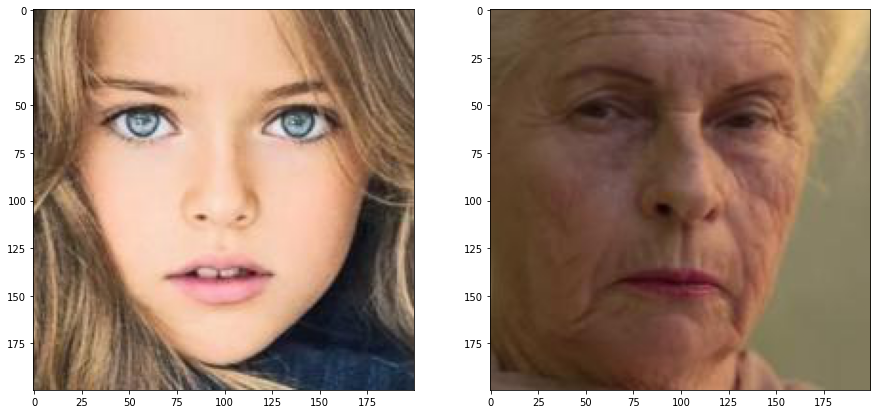

In [10]:
# Visualize the images 
base = plt.imread(content_img_path)
style = plt.imread(style_img_path)

fig, ax = plt.subplots(1, 2, figsize = (15,15))
ax[0].imshow(base)
ax[1].imshow(style)

## Gram-Matrix & Loss Functions

In [11]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [12]:
def cost_style(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def cost_content(base, combination): 
    return tf.reduce_sum(tf.square(combination-base))

## Import pre-trained model VGG19

In [17]:
# Import VGG19
#model = vgg19.VGG19(weights = "imagenet", include_top = False)
#model.summary()

# Import VGG16
model = vgg16.VGG16(weights = "imagenet", include_top = False)
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [18]:
# --- Extract the value for some layers ---
# List of model layers
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Extract features 
feature_extractor = Model(inputs = model.inputs, outputs = outputs_dict)

In [19]:
# Define layers to extract for style - Use first convolution of each block to calculate loss. 
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Define layers to extract for the content - Use the second convolution of the last block.
content_layers = "block5_conv2"

# Initialize weights. 
content_weight = 2.5e-8
style_weight = 1e-6


def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss in zero
    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[content_layers]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * cost_content(
        base_image_features, combination_features
    )
    # 5. Extract the style layers + style loss
    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = cost_style(style_reference_features, combination_features)
        loss += (style_weight / len(style_layers)) * sl

    return loss


## Learning Phase: Optimize Network

In [20]:
# Use GradientTape to calculate gradient (optimal values)
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


## Preprocessing and deprocessing images

In [21]:
# Give images the format required by the network. 
# VGG19 has a preprocess_input function

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors

    # Load the image
    #img = keras.preprocessing.image.load_img(
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )

    # Convert image to an array 
    #img = keras.preprocessing.image.img_to_array(img)
    img = tf.keras.utils.img_to_array(img)
    
    # Group images in a single array of dim (3 ,width, height, 3)
    img = np.expand_dims(img, axis=0)

    # Pre-process: substract mean of RGB vaues. 
    img = vgg19.preprocess_input(img)

    # convert to tensor
    return tf.convert_to_tensor(img)

In [22]:
# Revert the processing of images 

def deprocess_image(x):

    # Convert tensor into array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Add average value for each channel
    # Values can be found here: https://github.com/DeepVoltaire/AutoAugment/issues/4
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convert from BGR a RGB.
    x = x[:, :, ::-1]

    # Make values between 0 and 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x


## Training Of Neural Style Transfer Network 

In [23]:
# Define hyperparams: initial learning rate, decay steps, decay rate. 
ilr=100.0
ds=100
dr=0.96

# Define number of iterations 
iterations = 4000

In [24]:
# Save the result every n iterations (If required)
def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  #keras.preprocessing.image.save_img(image_name, img)
  tf.keras.utils.save_img(image_name,img)

In [25]:
# Define width and height 
#width, height = keras.preprocessing.image.load_img(base_img_path).size
width, height = tf.keras.utils.load_img(content_img_path).size

# Define number of rows and columns 
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# Set optimizer 
optimizer = SGD(
    #keras.optimizers.schedules.ExponentialDecay(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=ilr, decay_steps=ds, decay_rate=dr
    )
)

# Preprocess content image, style and combination (content)
content_image = preprocess_image(content_img_path)
style_reference_image = preprocess_image(style_img_path)
combination_image = tf.Variable(preprocess_image(content_img_path))

# Loop to get gradients 
for i in range(1, iterations + 1):
    # update loss and gradient
    loss, grads = compute_loss_and_grads(
        combination_image, content_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    # Print progress every 500 iterations
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 100: loss=691.93
Iteration 200: loss=475.15
Iteration 300: loss=383.85
Iteration 400: loss=332.23
Iteration 500: loss=298.47
Iteration 600: loss=274.29
Iteration 700: loss=255.93
Iteration 800: loss=241.41
Iteration 900: loss=229.59
Iteration 1000: loss=219.73
Iteration 1100: loss=211.36
Iteration 1200: loss=204.16
Iteration 1300: loss=197.88
Iteration 1400: loss=192.35
Iteration 1500: loss=187.44
Iteration 1600: loss=183.05
Iteration 1700: loss=179.10
Iteration 1800: loss=175.53
Iteration 1900: loss=172.28
Iteration 2000: loss=169.32
Iteration 2100: loss=166.61
Iteration 2200: loss=164.11
Iteration 2300: loss=161.81
Iteration 2400: loss=159.69
Iteration 2500: loss=157.72
Iteration 2600: loss=155.89
Iteration 2700: loss=154.19
Iteration 2800: loss=152.61
Iteration 2900: loss=151.13
Iteration 3000: loss=149.74
Iteration 3100: loss=148.44
Iteration 3200: loss=147.23
Iteration 3300: loss=146.08
Iteration 3400: loss=145.01
Iteration 3500: loss=144.00
Iteration 3600: loss=143.04
I

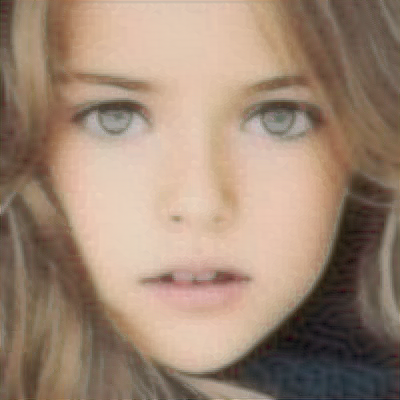

In [26]:
from PIL import Image as im 

# Print final image 
final_img = deprocess_image(combination_image.numpy())
im.fromarray(final_img)

